In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Model selection & metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [11]:
X_train = np.load('../new_artifacts/X_train_smote.npz', allow_pickle=True)['arr_0']
y_train = np.load('../new_artifacts/Y_train_smote.npz', allow_pickle=True)['arr_0']
X_test = np.load('../new_artifacts/X_test_smote.npz', allow_pickle=True)['arr_0']
y_test = np.load('../new_artifacts/Y_test_smote.npz', allow_pickle=True)['arr_0']

feature_names = np.load('../new_artifacts/feature_names.npy', allow_pickle=True)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (8278, 54) (8278,)
Test shape: (1409, 54) (1409,)


### 1. Utility Functions

In [35]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, cv=5, plot_importance=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        if hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test)
        else:
            y_proba = y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=cv), scoring='f1')

    print(f"===== {model_name} =====")
    print(classification_report(y_test, y_pred))
    print(f"Cross-validation F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, 
           annot=True, 
           fmt='d', 
           xticklabels=['No Churn', 'Churn'],  
           yticklabels=['No Churn', 'Churn'], 
           cbar_kws={'label': 'Count'})     

    plt.title(f'{model_name} Confusion Matrix', fontsize=14, pad=20)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()  
    plt.show()

   # Feature importance
    importance_dict = None
    if plot_importance and hasattr(model, 'feature_importances_'):
        importance_dict = dict(zip(feature_names, model.feature_importances_))
        importance_sorted = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
        features = list(importance_sorted.keys())
        importances = list(importance_sorted.values())
        colors = plt.cm.viridis(np.array(importances) / max(importances))

        plt.figure(figsize=(10, 14))
        bars = plt.barh(features, importances, color=colors, edgecolor="black")
        plt.gca().invert_yaxis()
        plt.title(f"{model_name} Feature Importances", fontsize=16, fontweight="bold")
        plt.xlabel("Importance", fontsize=13)
        plt.ylabel("Feature", fontsize=13)

 
        plt.grid(axis="x", linestyle="--", alpha=0.6)

        for bar, imp in zip(bars, importances):
            plt.text(bar.get_width() + 0.01, 
                    bar.get_y() + bar.get_height()/2,
                    f"{imp:.3f}", 
                    va="center", fontsize=10)

        plt.tight_layout()
        plt.show()



    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'ROC-AUC': roc,
        'CV-F1': cv_scores.mean(),
        'Feature Importance': importance_dict
    }


### 2. Initial Models

===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Cross-validation F1 score: 0.7822 (+/- 0.0132)


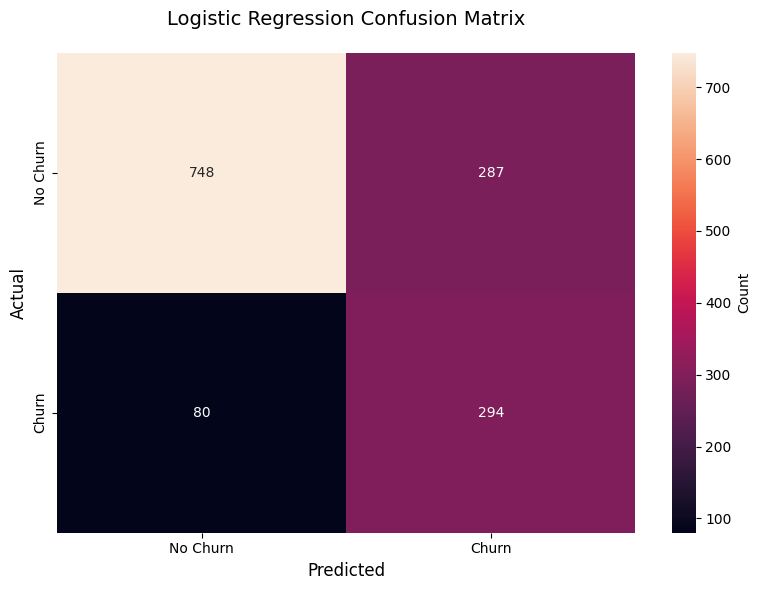

===== Decision Tree =====
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1035
           1       0.50      0.56      0.53       374

    accuracy                           0.74      1409
   macro avg       0.67      0.68      0.67      1409
weighted avg       0.75      0.74      0.74      1409

Cross-validation F1 score: 0.7865 (+/- 0.0813)


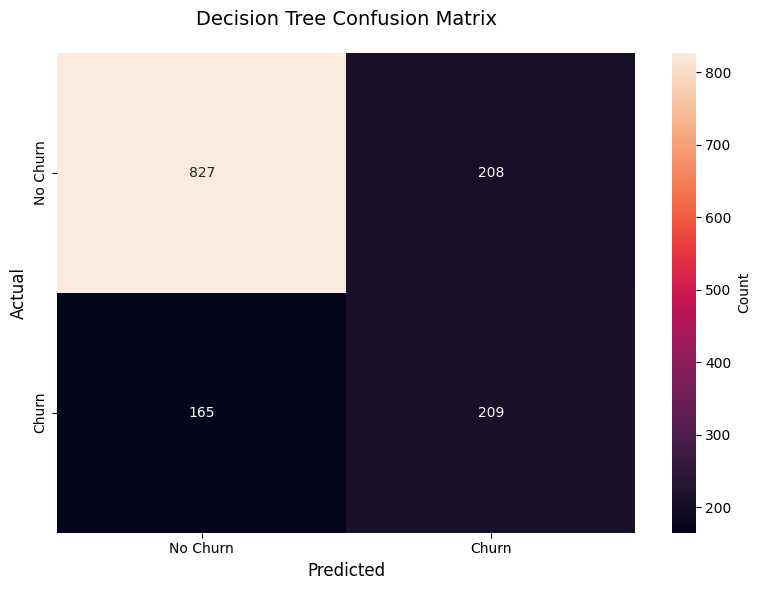

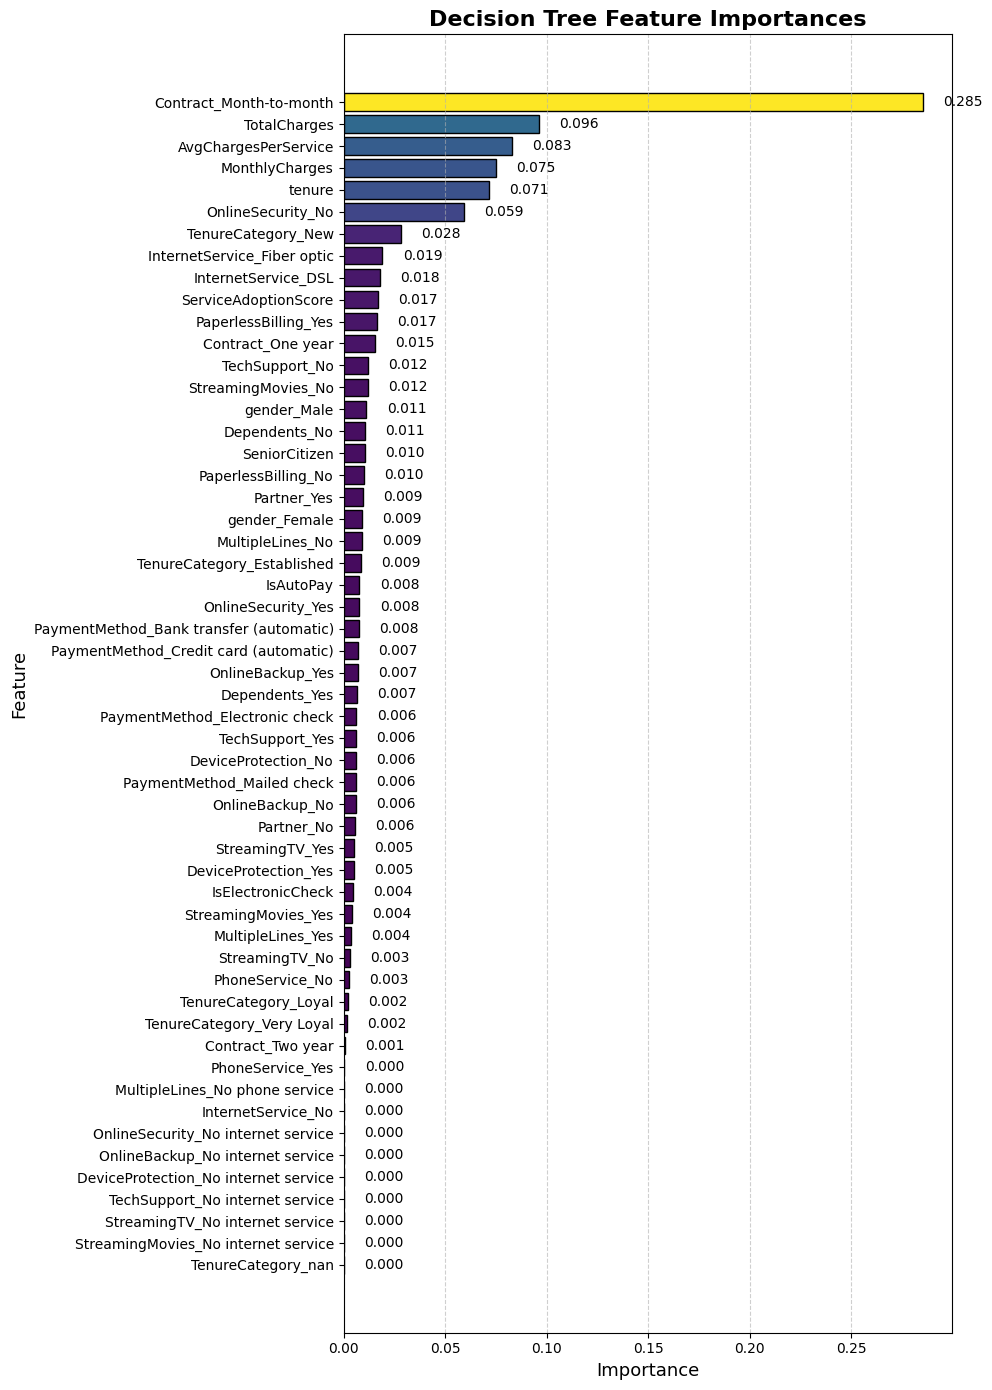

===== Random Forest Basic =====
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1035
           1       0.56      0.54      0.55       374

    accuracy                           0.77      1409
   macro avg       0.70      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409

Cross-validation F1 score: 0.8465 (+/- 0.0837)


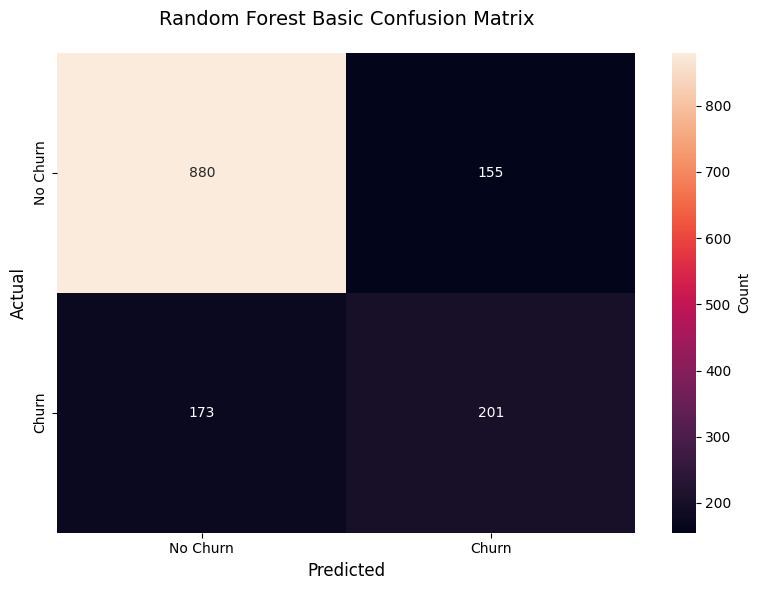

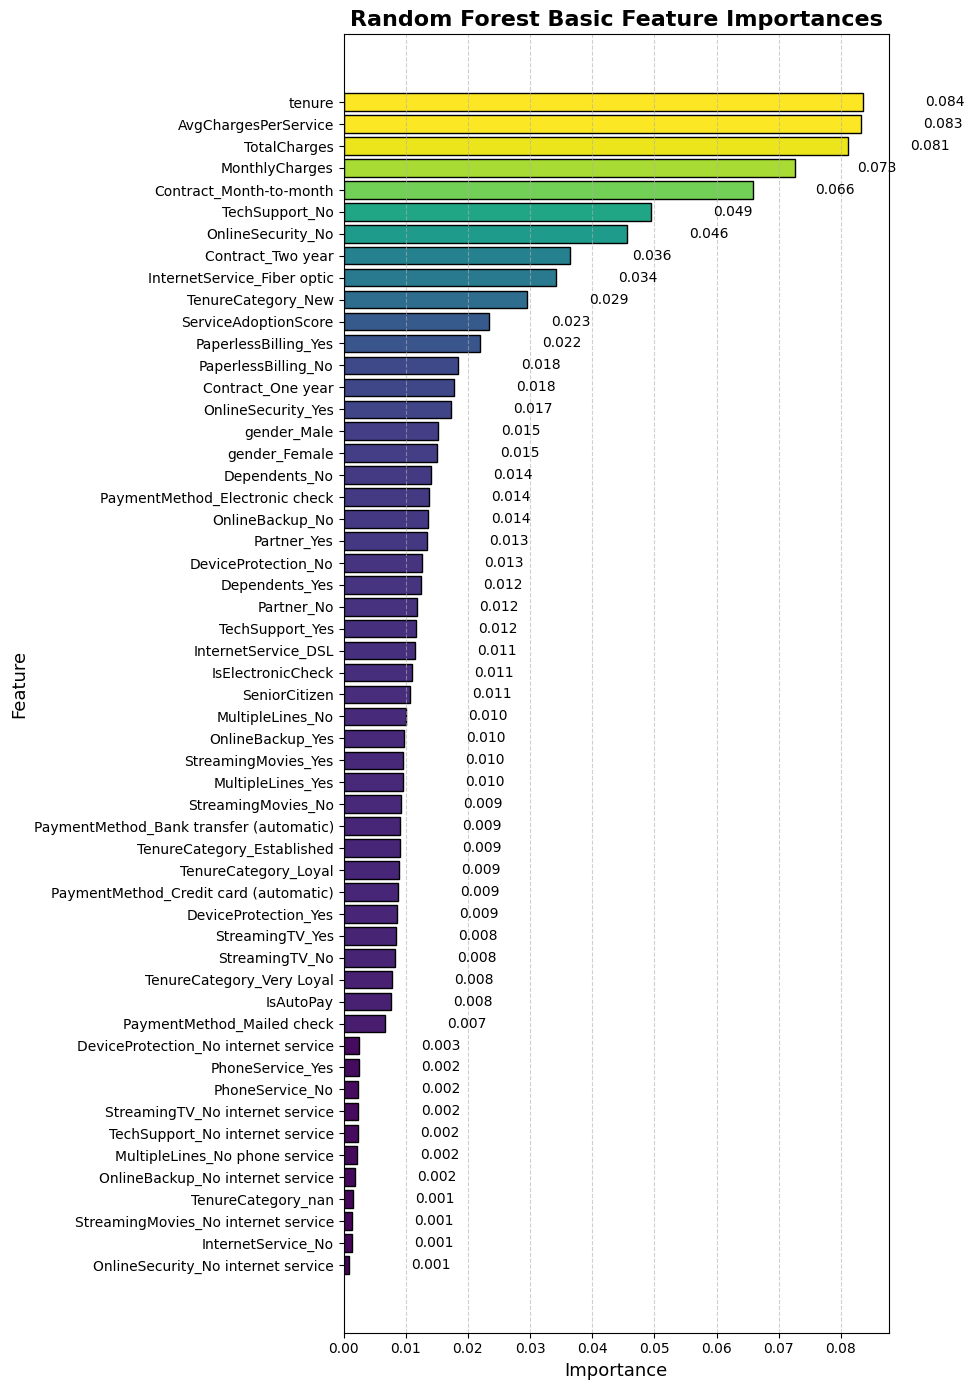

===== XGBoost Basic =====
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1035
           1       0.56      0.57      0.57       374

    accuracy                           0.77      1409
   macro avg       0.70      0.71      0.70      1409
weighted avg       0.77      0.77      0.77      1409

Cross-validation F1 score: 0.8232 (+/- 0.1140)


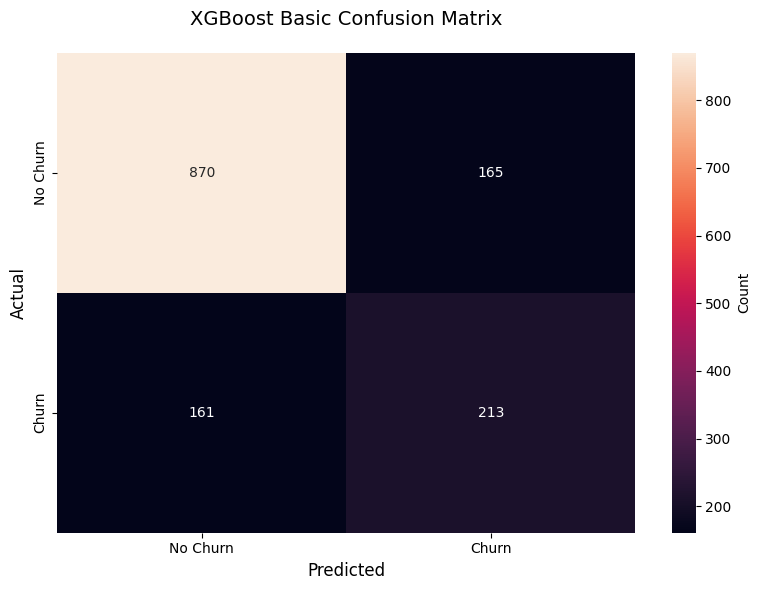

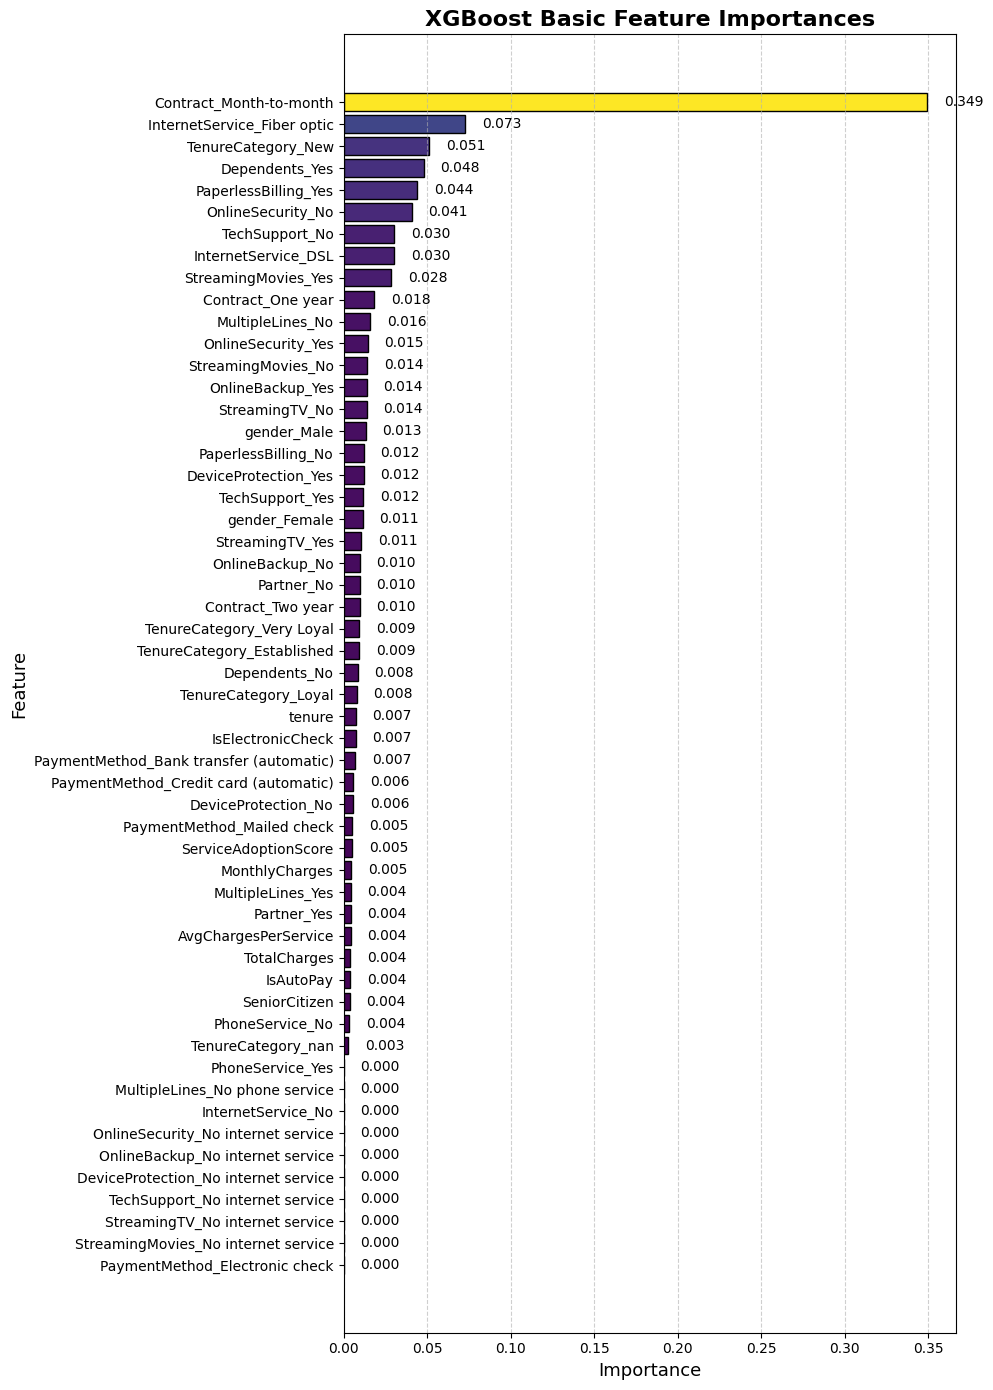

===== CatBoost Basic =====
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1035
           1       0.60      0.58      0.59       374

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Cross-validation F1 score: 0.8237 (+/- 0.1160)


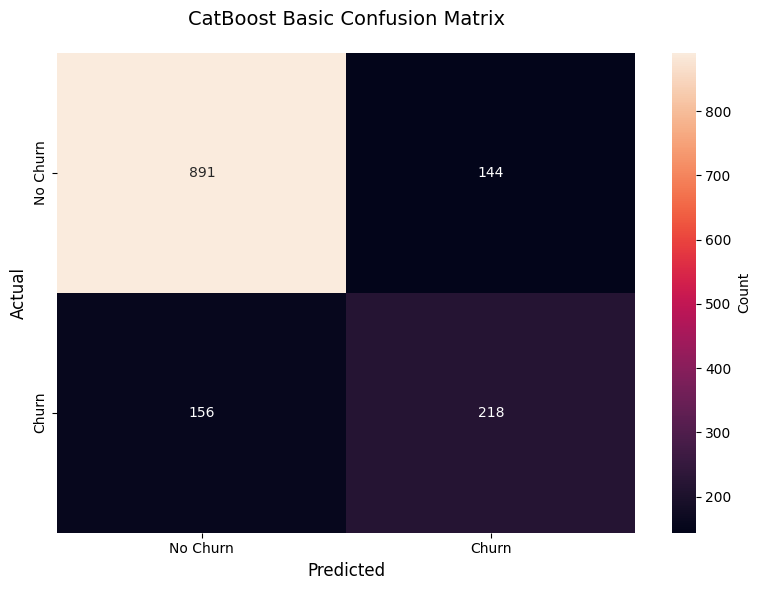

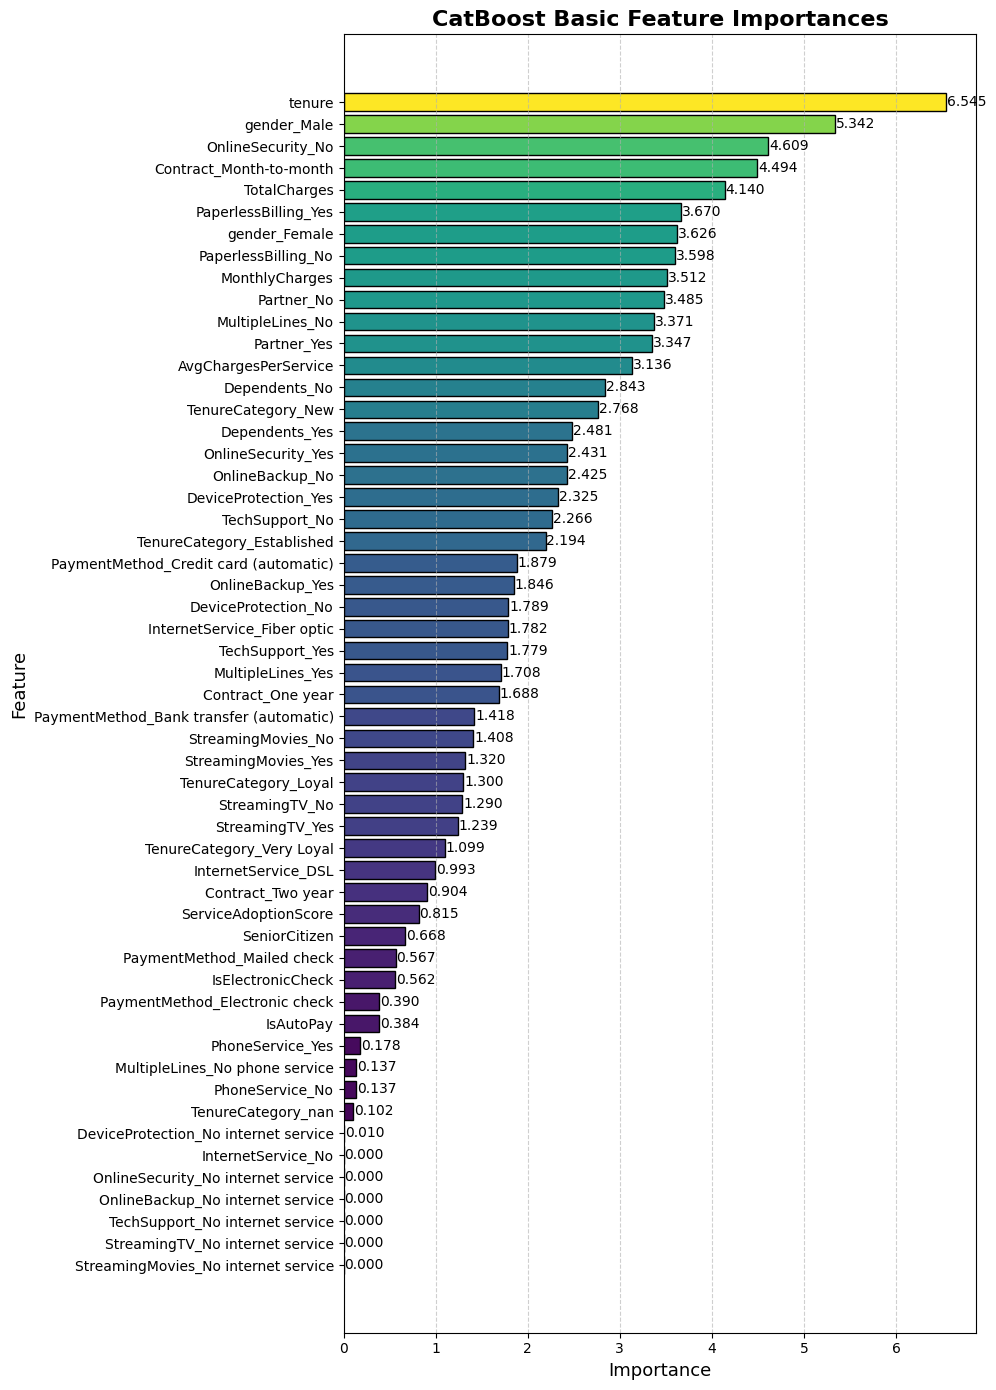

In [36]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest Basic': RandomForestClassifier(random_state=42),
    'XGBoost Basic': XGBClassifier(eval_metric='logloss', random_state=42),
    'CatBoost Basic': CatBoostClassifier(verbose=0, random_state=42)
}

os.makedirs("../JoblibModels", exist_ok=True)

results = []
for name, model in models.items():
    res = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results.append(res)

   
    safe_name = name.replace(" ", "_")  
    joblib.dump(model, f"../JoblibModels/{safe_name}.pkl")

### 3. Tuned Models


Best Random Forest Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
===== Random Forest Tuned =====
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1035
           1       0.56      0.55      0.55       374

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.76      0.77      0.76      1409

Cross-validation F1 score: 0.8487 (+/- 0.0793)


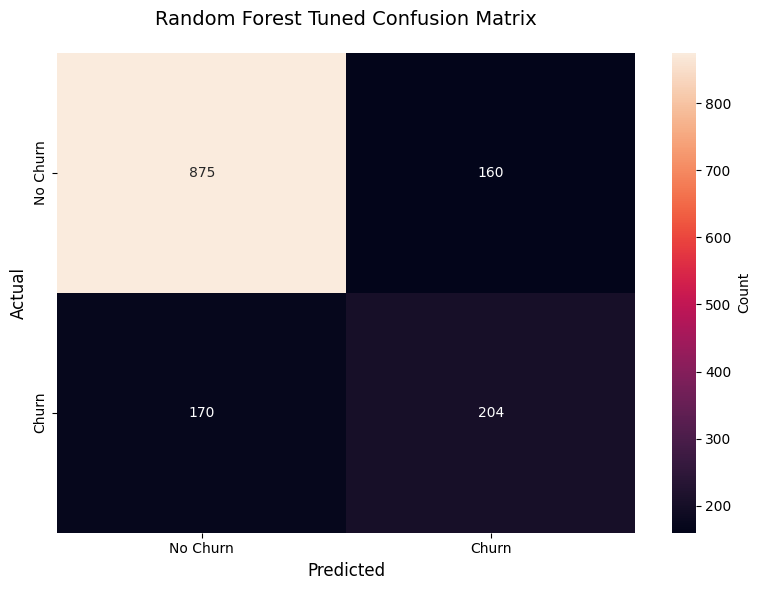

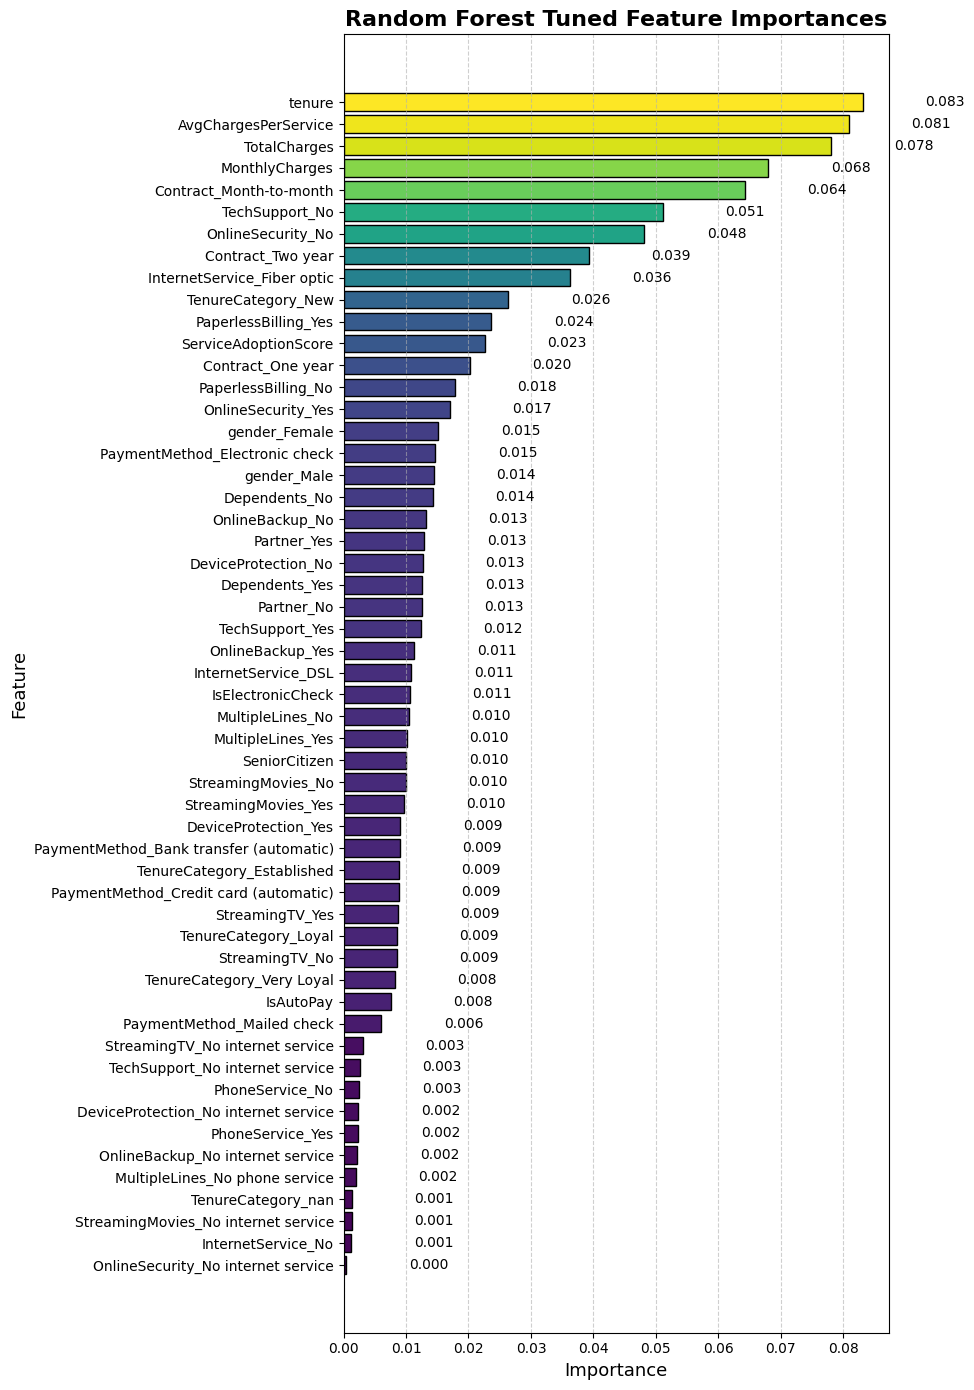


Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
===== XGBoost Tuned =====
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.56      0.74      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.78      1409

Cross-validation F1 score: 0.8337 (+/- 0.0540)


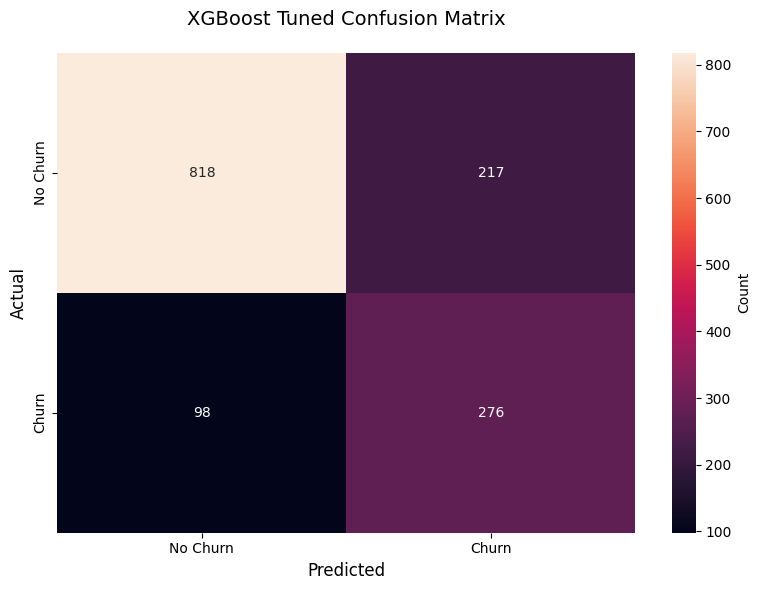

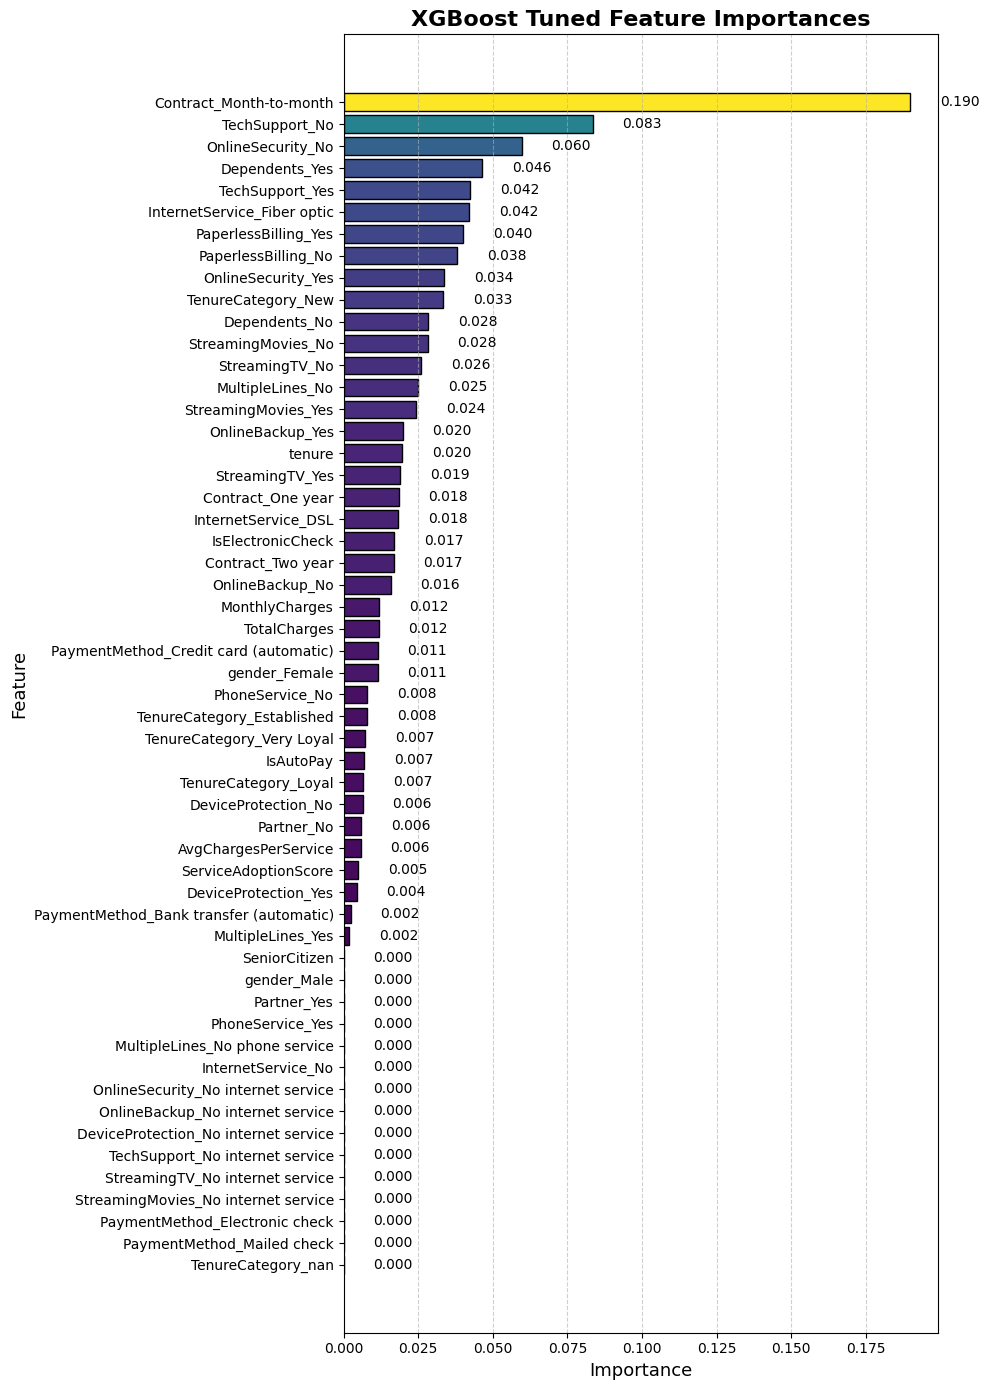


Best CatBoost Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.05}
===== CatBoost Tuned =====
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1035
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

Cross-validation F1 score: 0.8296 (+/- 0.0973)


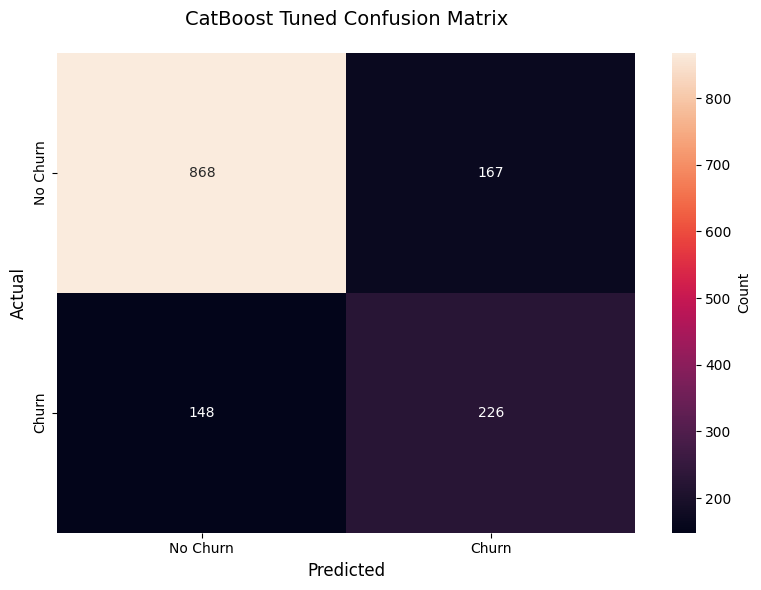

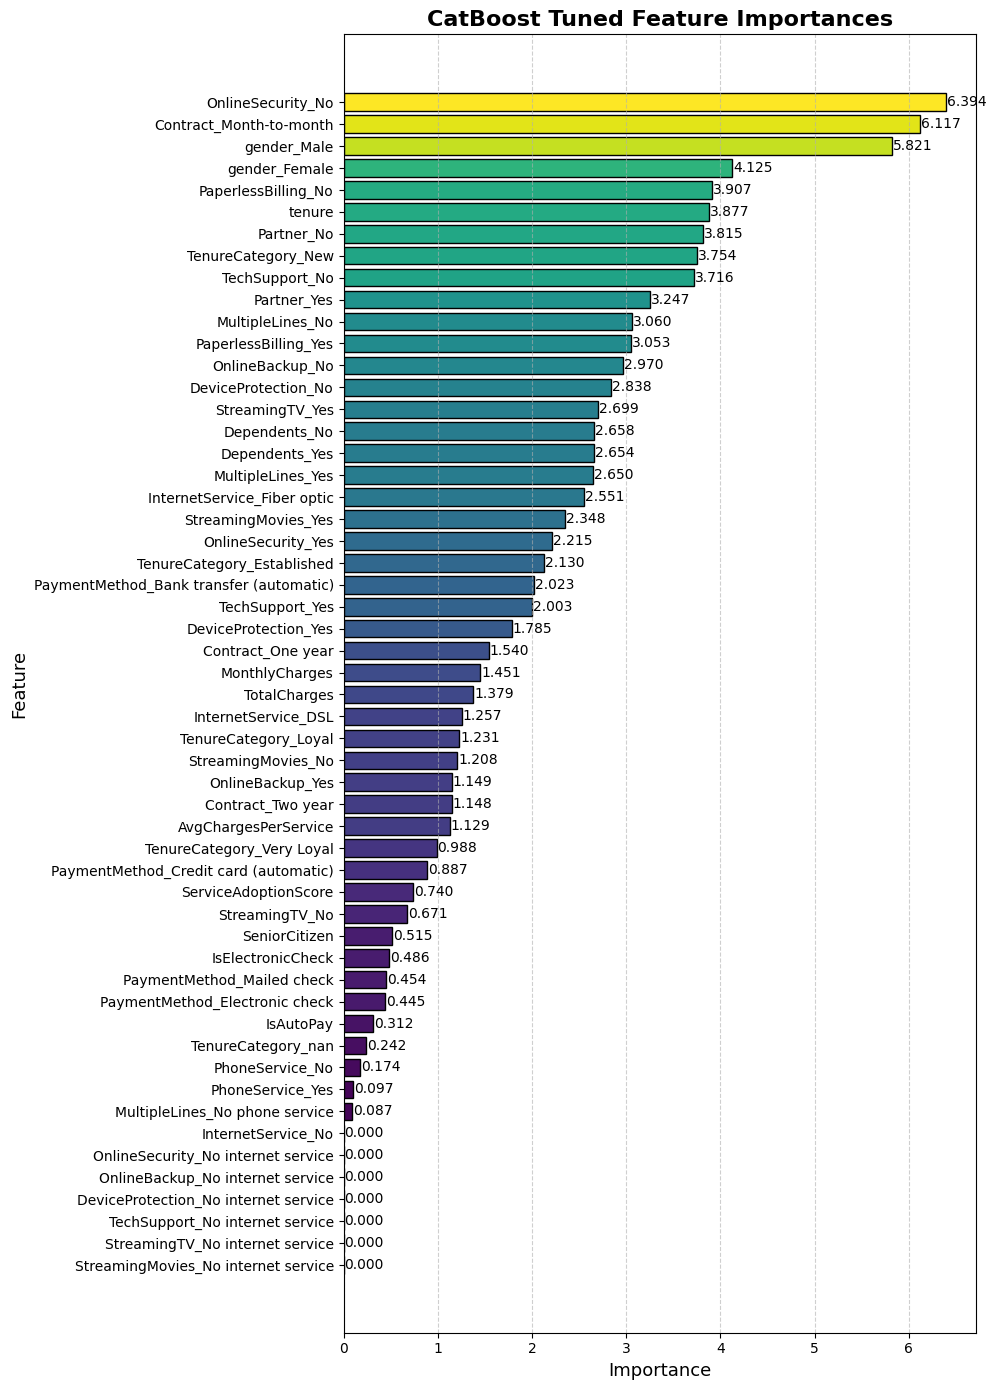

['../JoblibModels/CatBoost_Tuned.pkl']

In [37]:

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', None]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print("\nBest Random Forest Parameters:", rf_grid.best_params_)

rf_best = rf_grid.best_estimator_
res = evaluate_model(rf_best, X_train, y_train, X_test, y_test, 'Random Forest Tuned')
results.append(res)

joblib.dump(rf_best, "../JoblibModels/Random_Forest_Tuned.pkl")



xgb_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1]
}

xgb_grid = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    xgb_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
print("\nBest XGBoost Parameters:", xgb_grid.best_params_)

xgb_best = xgb_grid.best_estimator_
res = evaluate_model(xgb_best, X_train, y_train, X_test, y_test, 'XGBoost Tuned')
results.append(res)

joblib.dump(xgb_best, "../JoblibModels/XGBoost_Tuned.pkl")




cat_params = {
    'depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'iterations': [200, 500]
}

cat_grid = GridSearchCV(
    CatBoostClassifier(verbose=0, random_state=42),
    cat_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

cat_grid.fit(X_train, y_train)
print("\nBest CatBoost Parameters:", cat_grid.best_params_)

cat_best = cat_grid.best_estimator_
res = evaluate_model(cat_best, X_train, y_train, X_test, y_test, 'CatBoost Tuned')
results.append(res)

joblib.dump(cat_best, "../JoblibModels/CatBoost_Tuned.pkl")


### 4. Final Results Comparission

===== Model Performance Table =====
                     Accuracy  Precision  Recall      F1  ROC-AUC   CV-F1  \
Model                                                                       
Logistic Regression    0.7395     0.5060  0.7861  0.6157   0.8407  0.7822   
Decision Tree          0.7353     0.5012  0.5588  0.5284   0.6787  0.7865   
Random Forest Basic    0.7672     0.5646  0.5374  0.5507   0.8184  0.8465   
XGBoost Basic          0.7686     0.5635  0.5695  0.5665   0.8164  0.8232   
CatBoost Basic         0.7871     0.6022  0.5829  0.5924   0.8333  0.8237   
Random Forest Tuned    0.7658     0.5604  0.5455  0.5528   0.8201  0.8487   
XGBoost Tuned          0.7764     0.5598  0.7380  0.6367   0.8439  0.8337   
CatBoost Tuned         0.7764     0.5751  0.6043  0.5893   0.8399  0.8296   

                                                    Feature Importance  
Model                                                                   
Logistic Regression                            

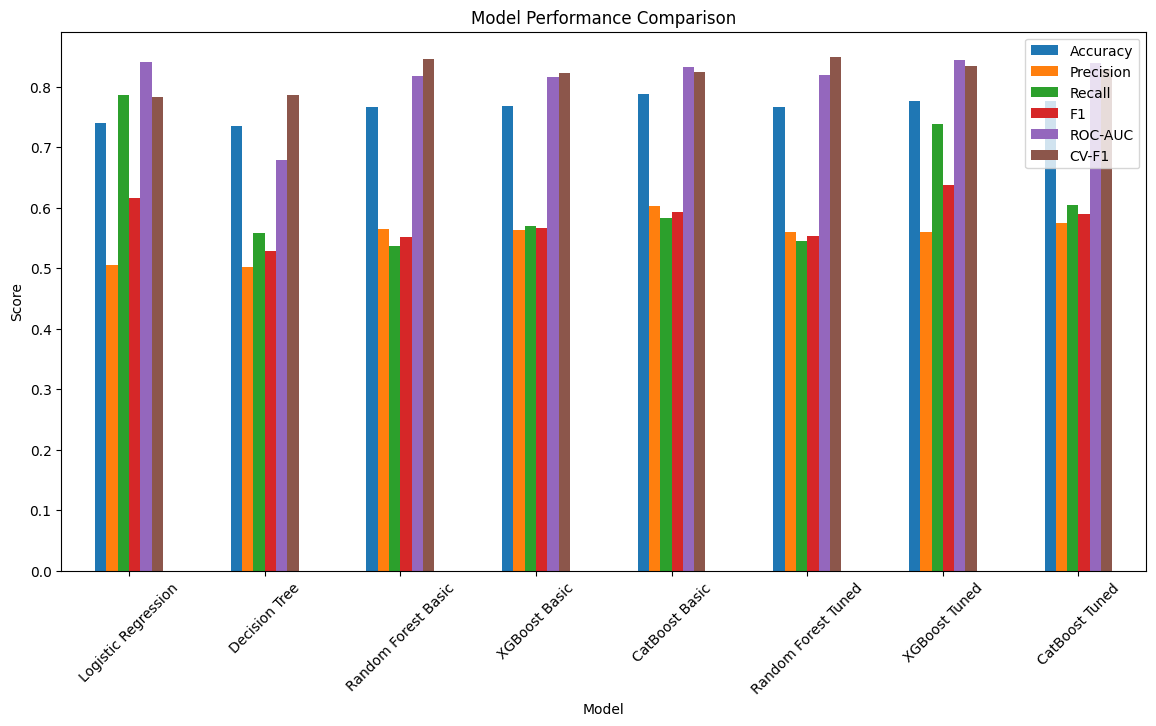

In [38]:
results_df = pd.DataFrame(results)
print("===== Model Performance Table =====")
print(results_df.set_index("Model").round(4))  


metrics = ['Accuracy','Precision','Recall','F1','ROC-AUC','CV-F1']
best_per_metric = {
    metric: results_df.loc[results_df[metric].idxmax(), ['Model', metric]]
    for metric in metrics
}

print("\n===== Best Model per Metric =====")
for metric, row in best_per_metric.items():
    print(f"{metric}: {row['Model']} ({row[metric]:.4f})")


final_best_model = results_df.sort_values(by=['F1','ROC-AUC'], ascending=False).iloc[0]
print("\n===== Final Best Model Overall =====")
print(f"Model: {final_best_model['Model']} (F1={final_best_model['F1']:.4f}, ROC-AUC={final_best_model['ROC-AUC']:.4f})")


results_df.plot(x='Model', y=metrics, kind='bar', figsize=(14,7))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()
